# Importing

In [55]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn_som.som import SOM
import salishsea_tools.viz_tools as sa_vi
from sklearn import preprocessing


# Datasets Preparation

In [56]:
def datasets_preparation():
    
    ds = xr.open_dataset ('/results2/SalishSea/nowcast-green.202111/20mar22/SalishSea_1d_20220320_20220320_grid_T.nc')
    ds_bio = xr. open_dataset ('/results2/SalishSea/nowcast-green.202111/20mar22/SalishSea_1d_20220320_20220320_biol_T.nc')

    # Variable selection
    temp = ds.votemper
    saline = ds.vosaline
    date = pd.DatetimeIndex(ds['time_counter'].values)

    # Zooplankton variables
    micro = ds_bio.microzooplankton
    meso = ds_bio.mesozooplankton

    # Open the mesh mask
    mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
    mask = mesh.tmask.to_numpy()
    
    return (ds, temp, saline, date, mask, micro, meso)


# Masking

In [57]:
def masking (depth, temp, saline, mask, micro, meso):

    temp = temp.where(mask[0,depth]==1)
    saline = saline.where(mask[0,depth]==1)

    micro = micro.where(mask[0,depth]==1)
    meso = meso.where(mask[0,depth]==1)

    return (temp, saline, micro, meso)

# SOM

In [58]:
def som (depth, temp, saline):
    
    # Post processing 
    inputs = np.stack((temp[0,depth].values.flatten(), saline[0,depth].values.flatten()))
    indx = np.argwhere(~np.isnan(inputs[0]) & ~np.isnan(inputs[1])) 
    inputs2 = inputs[:,indx[:,0]]
    inputs3 = preprocessing.normalize(inputs2, norm= 'max')
    inputs3 = inputs3.transpose()

    # SOM
    temp_som = SOM(m=3, n=2, dim= inputs3[0,:].size, lr = 0.1)
    temp_som.fit(inputs3, epochs = 5)
    predictions = temp_som.predict(inputs3)

    # Post processing
    unique, counts = np.unique(predictions, return_counts=True)
    indx2 = np.full(inputs[0,:].size,np.nan)
    indx2[indx[:,0]] = predictions
    clusters = np.reshape(indx2,(898,398))   

    return (unique, counts, inputs2.transpose(), predictions, clusters)


# Printing

In [59]:
def printing (inputs, predictions, unique, counts):

    # Preparation of the dataframe
    d = {'temperature': inputs[:,0], 'salinity': inputs[:,1], 'cluster': predictions}
    df = pd.DataFrame(d) 

    # Calculating the metrics
    mean_temp = np.round(df.groupby('cluster')['temperature'].mean(), 2)
    mean_sal = np.round(df.groupby('cluster')['salinity'].mean(), 2)
    min_temp = np.round(df.groupby('cluster')['temperature'].min(), 2)
    max_temp = np.round(df.groupby('cluster')['temperature'].max(), 2)
    min_sal = np.round(df.groupby('cluster')['salinity'].min(), 2)
    max_sal = np.round(df.groupby('cluster')['salinity'].max(), 2)

    # Printing
    for i in unique:
            print('The amount of grid boxes for cluster ' + str(i), 'is ' + str(counts[i]), '\n')

            print ('The minimum temperature for cluster '+ str(i), 'is ' + str(min_temp[i]), 'degrees Celsius')
            print ('The maximum temperature for cluster '+ str(i), 'is ' + str(max_temp[i]), 'degrees Celsius')
            print ('The mean temperature for cluster '+ str(i), 'is ' + str(mean_temp[i]), 'degrees Celsius', '\n')

            print ('The minimum salinity for cluster '+ str(i), 'is ' + str(min_sal[i]), 'g/kg')
            print ('The maximum salinity for cluster '+ str(i), 'is ' + str(max_sal[i]), 'g/kg')
            print ('The mean salinity for cluster '+ str(i), 'is ' + str(mean_sal[i]), 'g/kg', '\n'*2)
        

# Plotting

In [60]:
def plotting (depth, clusters, unique, micro, meso):

    # Preparation of the dataarray 
    map = xr.DataArray(clusters,
                    coords = {'y': micro[0,depth].y, 'x': micro[0,depth].x},
                    dims = ['y','x'],
                    attrs=dict(description="Clusters of the performed self organizing map algorithm",
                                long_name ="Cluster",
                                units="count"),
                    ) 

    cmap = plt.get_cmap('viridis', unique.max()+1)
    cmap.set_bad('gray')
    fig, ax = plt.subplots(2,2, figsize=(10, 15))
    map.plot.pcolormesh(ax=ax[0,0], cmap=cmap, levels= np.concatenate((unique,[unique.size])), cbar_kwargs={'ticks': unique})
    
    plt.subplots_adjust(left=0.1,
        bottom=0.1, 
        right=0.9, 
        top=0.95, 
        wspace=0.15, 
        hspace=0.15)
        
    cmap = plt.get_cmap('Accent')
    cmap.set_bad('gray')
    micro[0,depth].plot.pcolormesh(ax=ax[0,1], cmap=cmap) 
    meso[0,depth].plot.pcolormesh(ax=ax[1,0], cmap=cmap) 

    sa_vi.set_aspect(ax[0,0])
    sa_vi.set_aspect(ax[0,1])
    sa_vi.set_aspect(ax[1,0])

    ax[0,0].title.set_text('Clustering')
    ax[0,1].title.set_text('Microzooplankton')
    ax[1,0].title.set_text('Mesozooplankton')

    if date[0].month < 10:
        month = '0' + str(date[0].month)
    else:
        month = str(date[0].month)

    if date[0].day < 10:
        day = '0' + str(date[0].day)  
    else:
        day = str(date[0].day) 

    fig.suptitle('Depth: ' + str(np.round(ds['deptht'][depth].values,2)) + ' meters, ' + str(date[0].year) + '/' + month + '/' + day)
    
    plt.show()


# Main FOR Loop From Where All Functions are Called

The amount of grid boxes for cluster 0 is 25966 

The minimum temperature for cluster 0 is 6.19 degrees Celsius
The maximum temperature for cluster 0 is 8.11 degrees Celsius
The mean temperature for cluster 0 is 7.69 degrees Celsius 

The minimum salinity for cluster 0 is 28.62 g/kg
The maximum salinity for cluster 0 is 31.2 g/kg
The mean salinity for cluster 0 is 30.06 g/kg 


The amount of grid boxes for cluster 1 is 17809 

The minimum temperature for cluster 1 is 7.6 degrees Celsius
The maximum temperature for cluster 1 is 8.89 degrees Celsius
The mean temperature for cluster 1 is 8.01 degrees Celsius 

The minimum salinity for cluster 1 is 27.25 g/kg
The maximum salinity for cluster 1 is 29.88 g/kg
The mean salinity for cluster 1 is 28.77 g/kg 


The amount of grid boxes for cluster 2 is 11940 

The minimum temperature for cluster 2 is 5.87 degrees Celsius
The maximum temperature for cluster 2 is 8.19 degrees Celsius
The mean temperature for cluster 2 is 7.62 degrees Celsius 

The

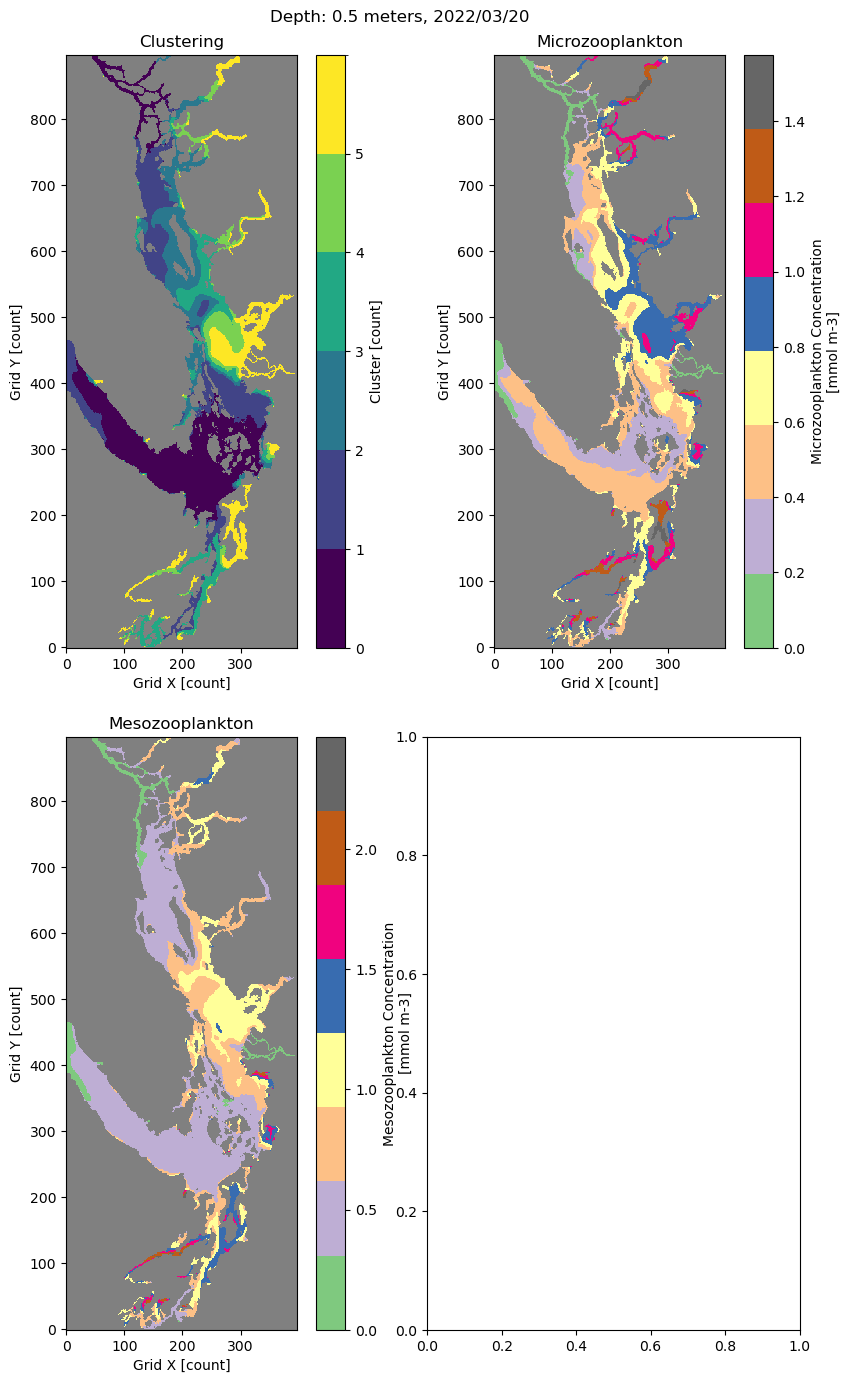

The amount of grid boxes for cluster 0 is 5648 

The minimum temperature for cluster 0 is 6.21 degrees Celsius
The maximum temperature for cluster 0 is 9.82 degrees Celsius
The mean temperature for cluster 0 is 7.65 degrees Celsius 

The minimum salinity for cluster 0 is 22.2 g/kg
The maximum salinity for cluster 0 is 26.06 g/kg
The mean salinity for cluster 0 is 23.96 g/kg 


The amount of grid boxes for cluster 1 is 10514 

The minimum temperature for cluster 1 is 5.12 degrees Celsius
The maximum temperature for cluster 1 is 9.6 degrees Celsius
The mean temperature for cluster 1 is 7.4 degrees Celsius 

The minimum salinity for cluster 1 is 0.0 g/kg
The maximum salinity for cluster 1 is 23.08 g/kg
The mean salinity for cluster 1 is 18.64 g/kg 


The amount of grid boxes for cluster 2 is 11991 

The minimum temperature for cluster 2 is 5.95 degrees Celsius
The maximum temperature for cluster 2 is 8.26 degrees Celsius
The mean temperature for cluster 2 is 7.63 degrees Celsius 

The min

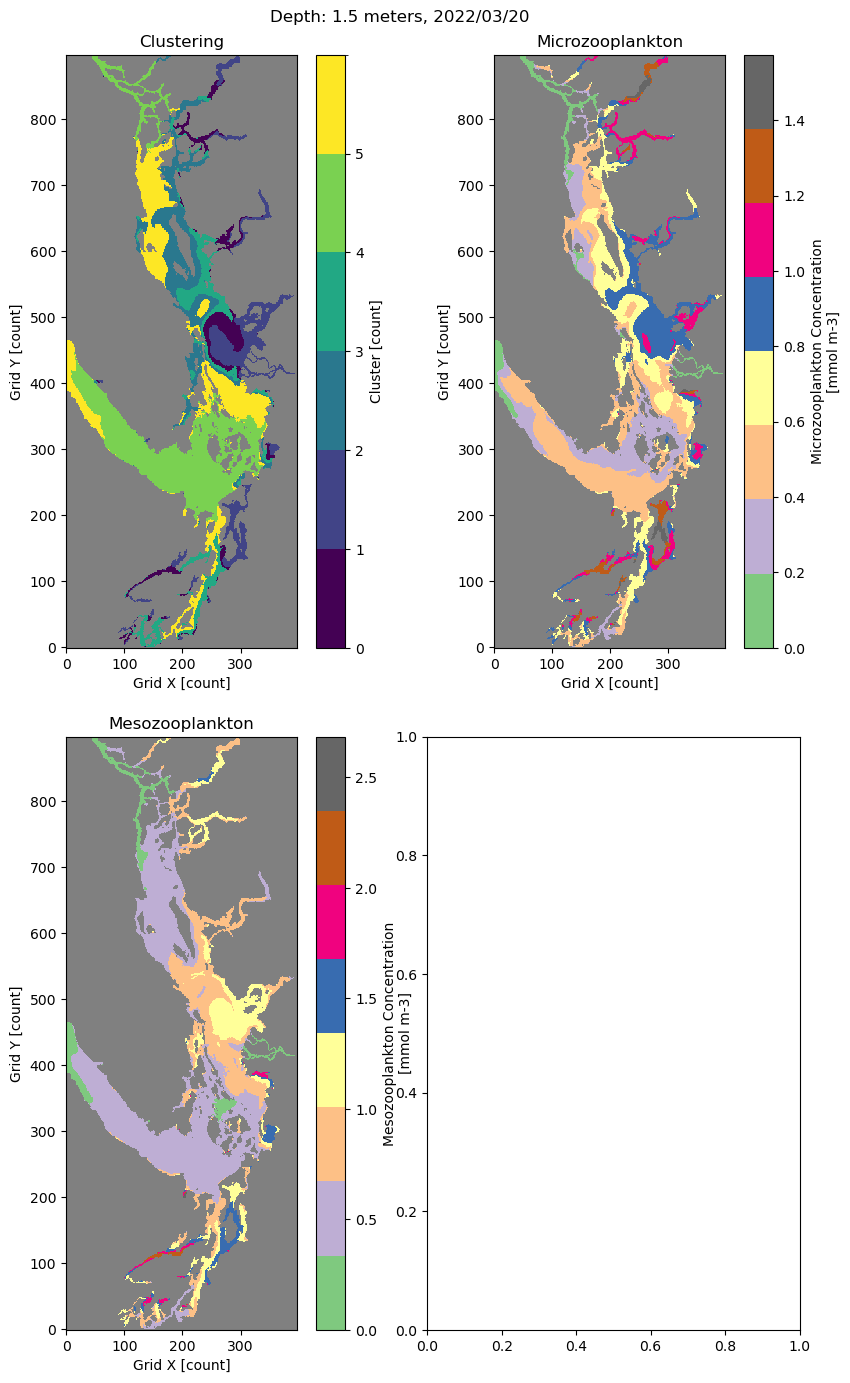

The amount of grid boxes for cluster 0 is 27349 

The minimum temperature for cluster 0 is 6.02 degrees Celsius
The maximum temperature for cluster 0 is 8.13 degrees Celsius
The mean temperature for cluster 0 is 7.7 degrees Celsius 

The minimum salinity for cluster 0 is 28.66 g/kg
The maximum salinity for cluster 0 is 31.23 g/kg
The mean salinity for cluster 0 is 30.08 g/kg 


The amount of grid boxes for cluster 1 is 17619 

The minimum temperature for cluster 1 is 7.65 degrees Celsius
The maximum temperature for cluster 1 is 10.04 degrees Celsius
The mean temperature for cluster 1 is 8.03 degrees Celsius 

The minimum salinity for cluster 1 is 27.24 g/kg
The maximum salinity for cluster 1 is 29.85 g/kg
The mean salinity for cluster 1 is 28.76 g/kg 


The amount of grid boxes for cluster 2 is 12751 

The minimum temperature for cluster 2 is 5.88 degrees Celsius
The maximum temperature for cluster 2 is 8.15 degrees Celsius
The mean temperature for cluster 2 is 7.6 degrees Celsius 

Th

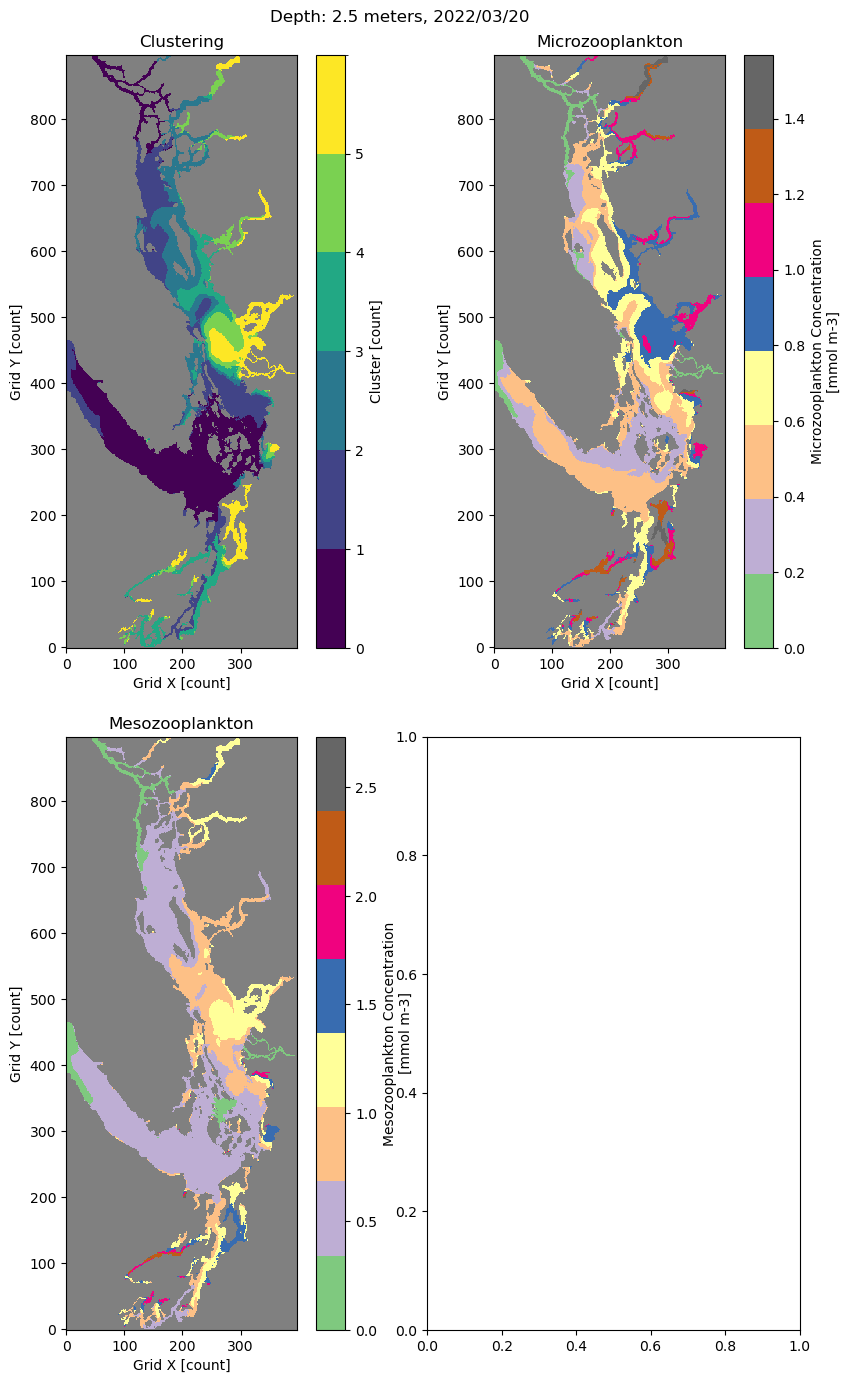

The amount of grid boxes for cluster 0 is 9315 

The minimum temperature for cluster 0 is 5.81 degrees Celsius
The maximum temperature for cluster 0 is 7.96 degrees Celsius
The mean temperature for cluster 0 is 7.62 degrees Celsius 

The minimum salinity for cluster 0 is 28.09 g/kg
The maximum salinity for cluster 0 is 29.85 g/kg
The mean salinity for cluster 0 is 28.68 g/kg 


The amount of grid boxes for cluster 1 is 28568 

The minimum temperature for cluster 1 is 6.82 degrees Celsius
The maximum temperature for cluster 1 is 8.5 degrees Celsius
The mean temperature for cluster 1 is 7.75 degrees Celsius 

The minimum salinity for cluster 1 is 29.11 g/kg
The maximum salinity for cluster 1 is 31.25 g/kg
The mean salinity for cluster 1 is 30.08 g/kg 


The amount of grid boxes for cluster 2 is 11515 

The minimum temperature for cluster 2 is 6.42 degrees Celsius
The maximum temperature for cluster 2 is 8.21 degrees Celsius
The mean temperature for cluster 2 is 7.56 degrees Celsius 

The

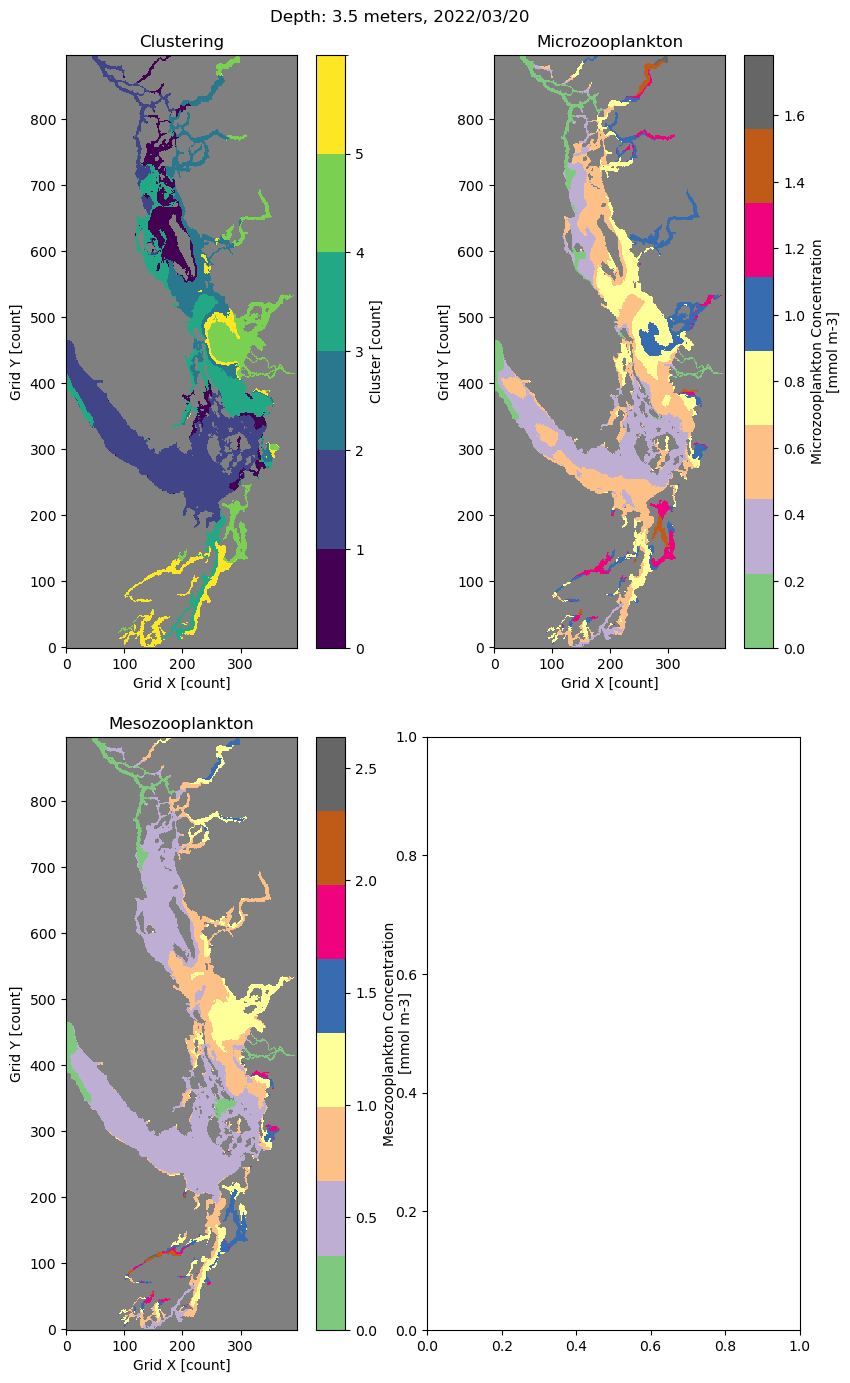

The amount of grid boxes for cluster 0 is 8319 

The minimum temperature for cluster 0 is 6.51 degrees Celsius
The maximum temperature for cluster 0 is 7.93 degrees Celsius
The mean temperature for cluster 0 is 7.47 degrees Celsius 

The minimum salinity for cluster 0 is 24.57 g/kg
The maximum salinity for cluster 0 is 27.57 g/kg
The mean salinity for cluster 0 is 26.33 g/kg 


The amount of grid boxes for cluster 1 is 8125 

The minimum temperature for cluster 1 is 5.12 degrees Celsius
The maximum temperature for cluster 1 is 9.38 degrees Celsius
The mean temperature for cluster 1 is 7.66 degrees Celsius 

The minimum salinity for cluster 1 is 0.0 g/kg
The maximum salinity for cluster 1 is 25.59 g/kg
The mean salinity for cluster 1 is 21.4 g/kg 


The amount of grid boxes for cluster 2 is 14001 

The minimum temperature for cluster 2 is 5.74 degrees Celsius
The maximum temperature for cluster 2 is 8.0 degrees Celsius
The mean temperature for cluster 2 is 7.64 degrees Celsius 

The min

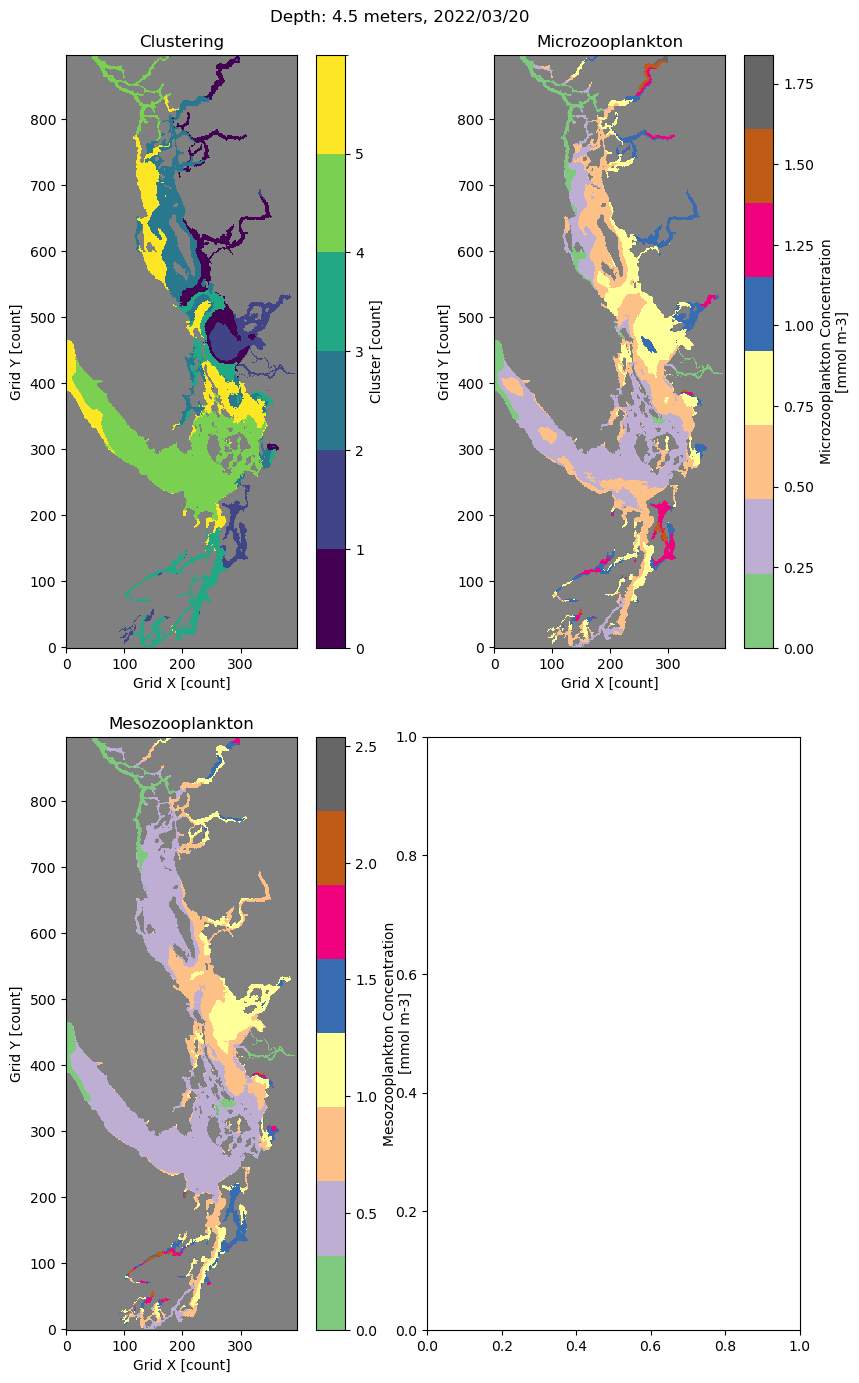

The amount of grid boxes for cluster 0 is 12765 

The minimum temperature for cluster 0 is 7.64 degrees Celsius
The maximum temperature for cluster 0 is 8.51 degrees Celsius
The mean temperature for cluster 0 is 7.96 degrees Celsius 

The minimum salinity for cluster 0 is 28.74 g/kg
The maximum salinity for cluster 0 is 30.21 g/kg
The mean salinity for cluster 0 is 29.28 g/kg 


The amount of grid boxes for cluster 1 is 24116 

The minimum temperature for cluster 1 is 5.74 degrees Celsius
The maximum temperature for cluster 1 is 7.97 degrees Celsius
The mean temperature for cluster 1 is 7.66 degrees Celsius 

The minimum salinity for cluster 1 is 28.85 g/kg
The maximum salinity for cluster 1 is 31.28 g/kg
The mean salinity for cluster 1 is 30.2 g/kg 


The amount of grid boxes for cluster 2 is 11531 

The minimum temperature for cluster 2 is 7.73 degrees Celsius
The maximum temperature for cluster 2 is 8.87 degrees Celsius
The mean temperature for cluster 2 is 8.03 degrees Celsius 

Th

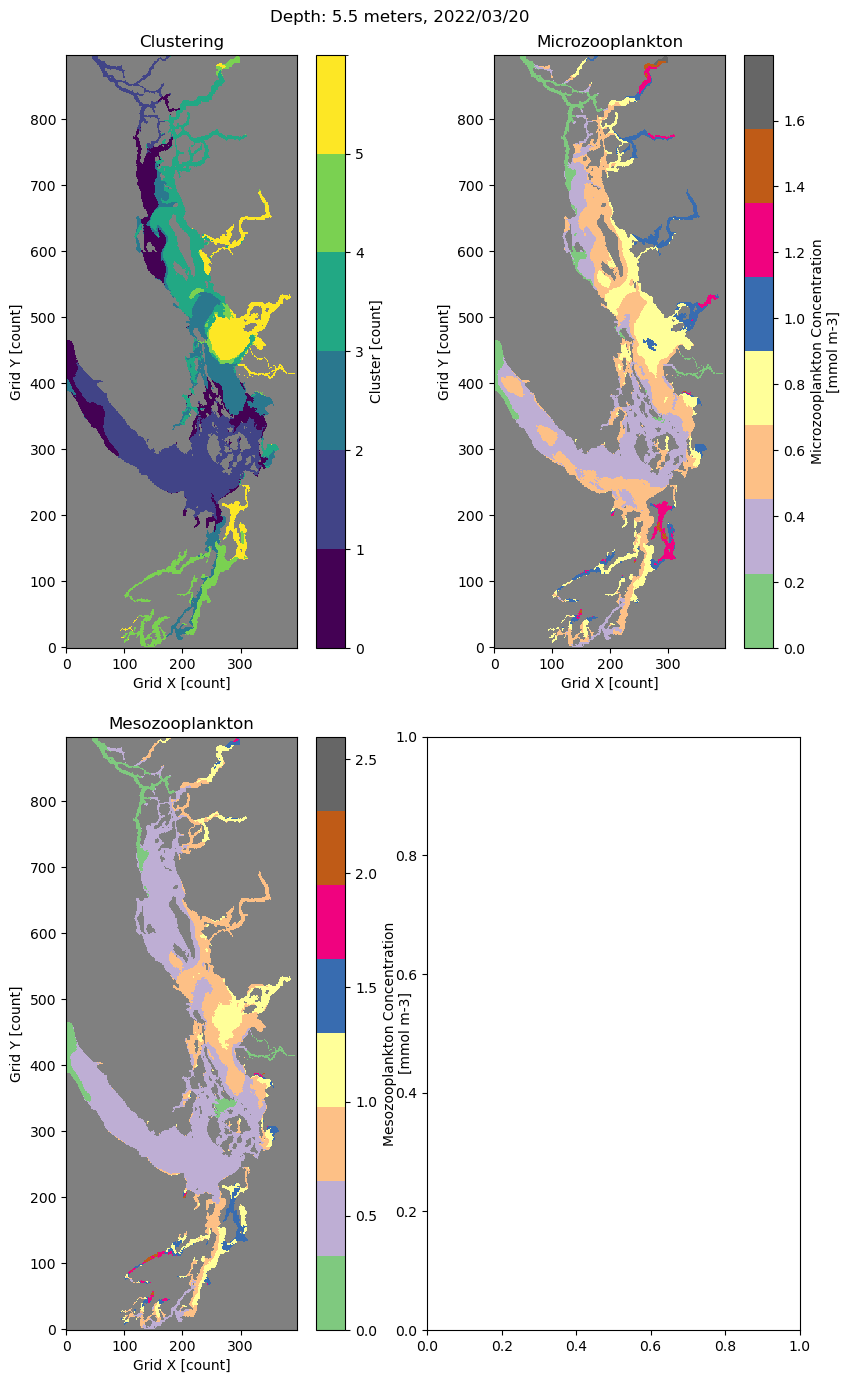

The amount of grid boxes for cluster 0 is 9757 

The minimum temperature for cluster 0 is 5.12 degrees Celsius
The maximum temperature for cluster 0 is 8.68 degrees Celsius
The mean temperature for cluster 0 is 7.47 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 27.37 g/kg
The mean salinity for cluster 0 is 24.73 g/kg 


The amount of grid boxes for cluster 1 is 7855 

The minimum temperature for cluster 1 is 7.84 degrees Celsius
The maximum temperature for cluster 1 is 10.24 degrees Celsius
The mean temperature for cluster 1 is 8.65 degrees Celsius 

The minimum salinity for cluster 1 is 22.39 g/kg
The maximum salinity for cluster 1 is 29.03 g/kg
The mean salinity for cluster 1 is 26.83 g/kg 


The amount of grid boxes for cluster 2 is 15362 

The minimum temperature for cluster 2 is 6.83 degrees Celsius
The maximum temperature for cluster 2 is 7.83 degrees Celsius
The mean temperature for cluster 2 is 7.57 degrees Celsius 

The 

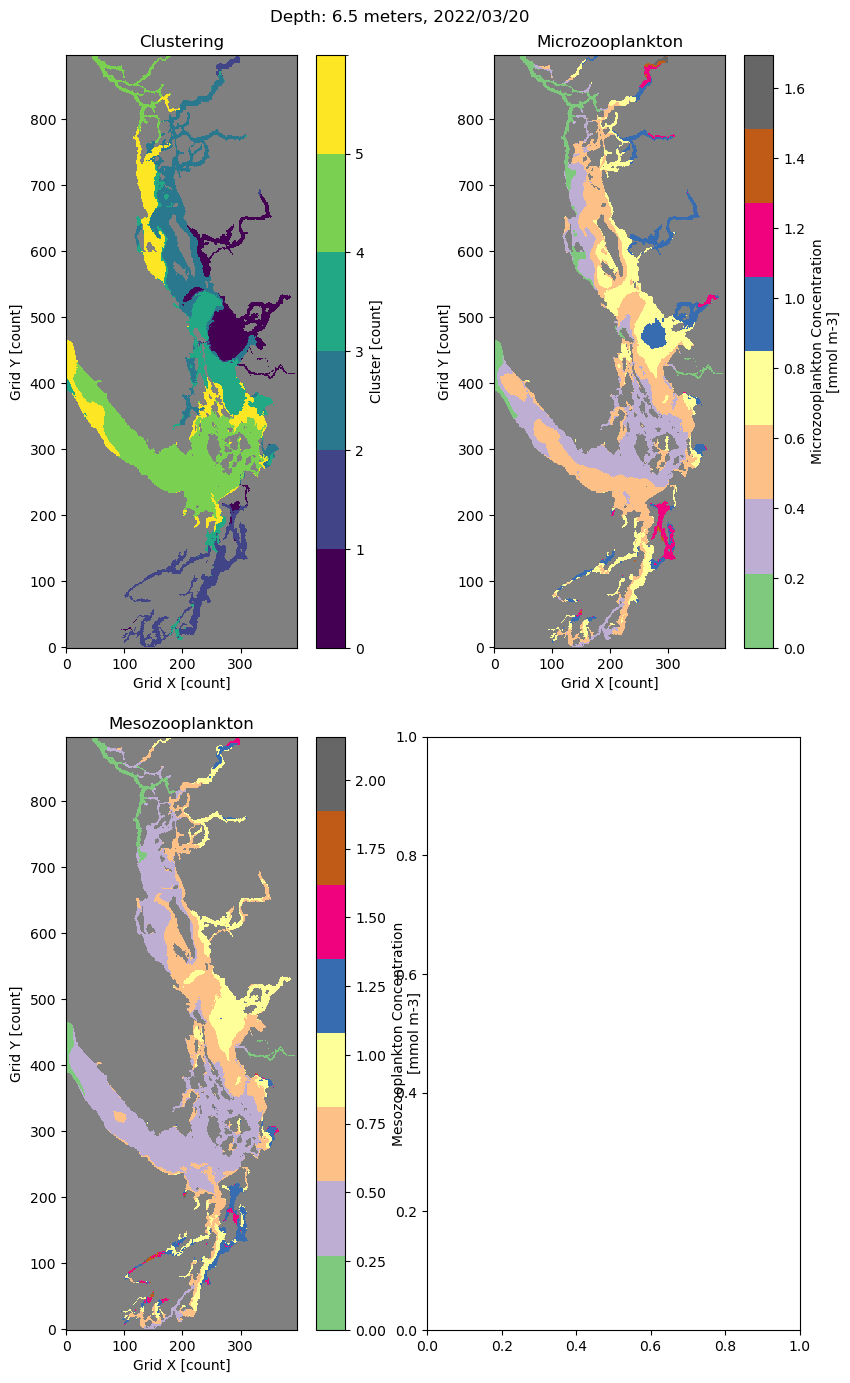

The amount of grid boxes for cluster 0 is 25311 

The minimum temperature for cluster 0 is 7.18 degrees Celsius
The maximum temperature for cluster 0 is 8.18 degrees Celsius
The mean temperature for cluster 0 is 7.74 degrees Celsius 

The minimum salinity for cluster 0 is 29.26 g/kg
The maximum salinity for cluster 0 is 31.3 g/kg
The mean salinity for cluster 0 is 30.22 g/kg 


The amount of grid boxes for cluster 1 is 4335 

The minimum temperature for cluster 1 is 5.75 degrees Celsius
The maximum temperature for cluster 1 is 7.82 degrees Celsius
The mean temperature for cluster 1 is 7.52 degrees Celsius 

The minimum salinity for cluster 1 is 28.7 g/kg
The maximum salinity for cluster 1 is 30.75 g/kg
The mean salinity for cluster 1 is 29.42 g/kg 


The amount of grid boxes for cluster 2 is 16349 

The minimum temperature for cluster 2 is 7.72 degrees Celsius
The maximum temperature for cluster 2 is 8.52 degrees Celsius
The mean temperature for cluster 2 is 7.99 degrees Celsius 

The 

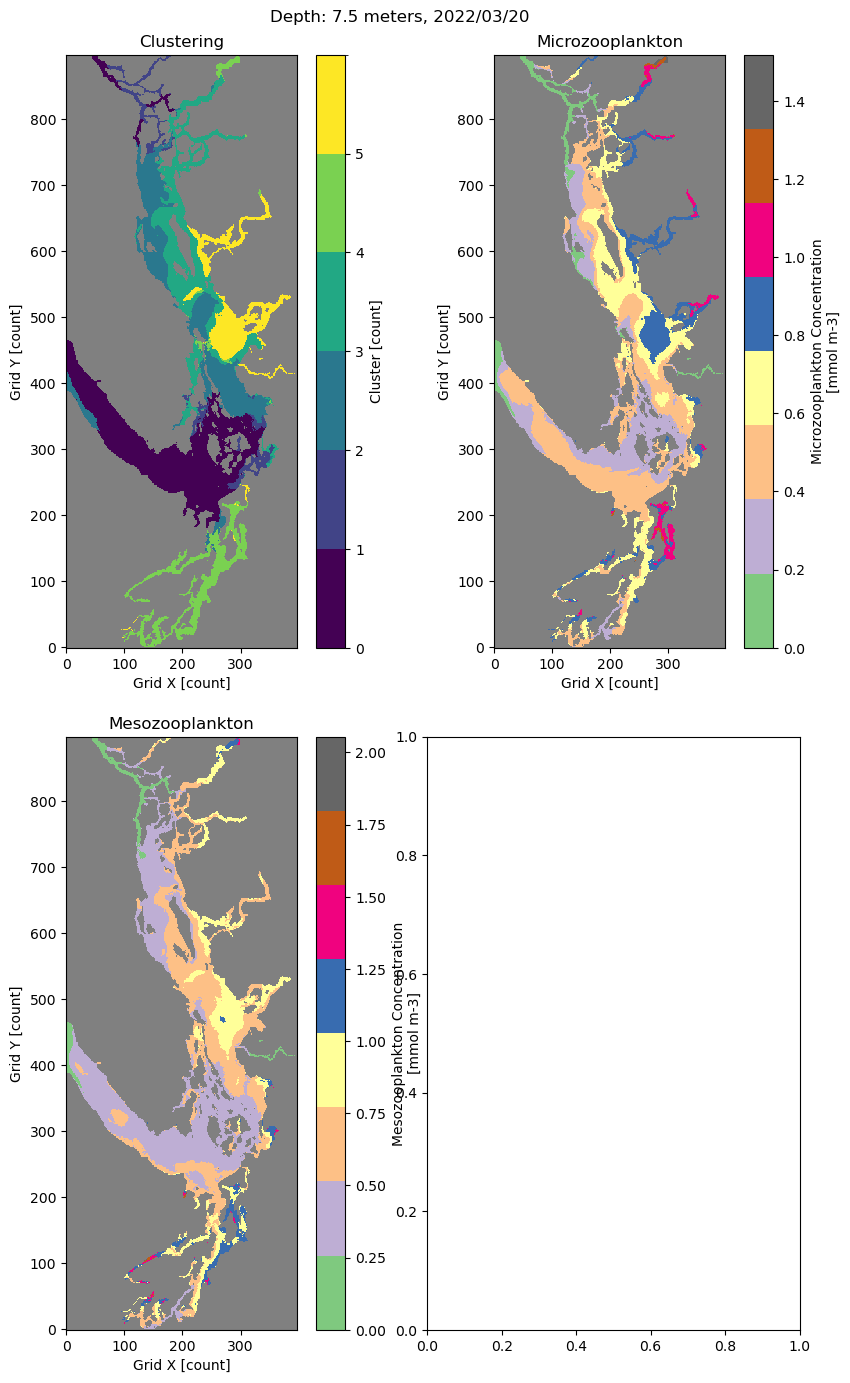

The amount of grid boxes for cluster 0 is 9842 

The minimum temperature for cluster 0 is 5.12 degrees Celsius
The maximum temperature for cluster 0 is 8.71 degrees Celsius
The mean temperature for cluster 0 is 7.55 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 28.14 g/kg
The mean salinity for cluster 0 is 26.11 g/kg 


The amount of grid boxes for cluster 1 is 9399 

The minimum temperature for cluster 1 is 7.96 degrees Celsius
The maximum temperature for cluster 1 is 10.23 degrees Celsius
The mean temperature for cluster 1 is 8.64 degrees Celsius 

The minimum salinity for cluster 1 is 23.25 g/kg
The maximum salinity for cluster 1 is 29.45 g/kg
The mean salinity for cluster 1 is 27.71 g/kg 


The amount of grid boxes for cluster 2 is 16414 

The minimum temperature for cluster 2 is 7.07 degrees Celsius
The maximum temperature for cluster 2 is 7.97 degrees Celsius
The mean temperature for cluster 2 is 7.61 degrees Celsius 

The 

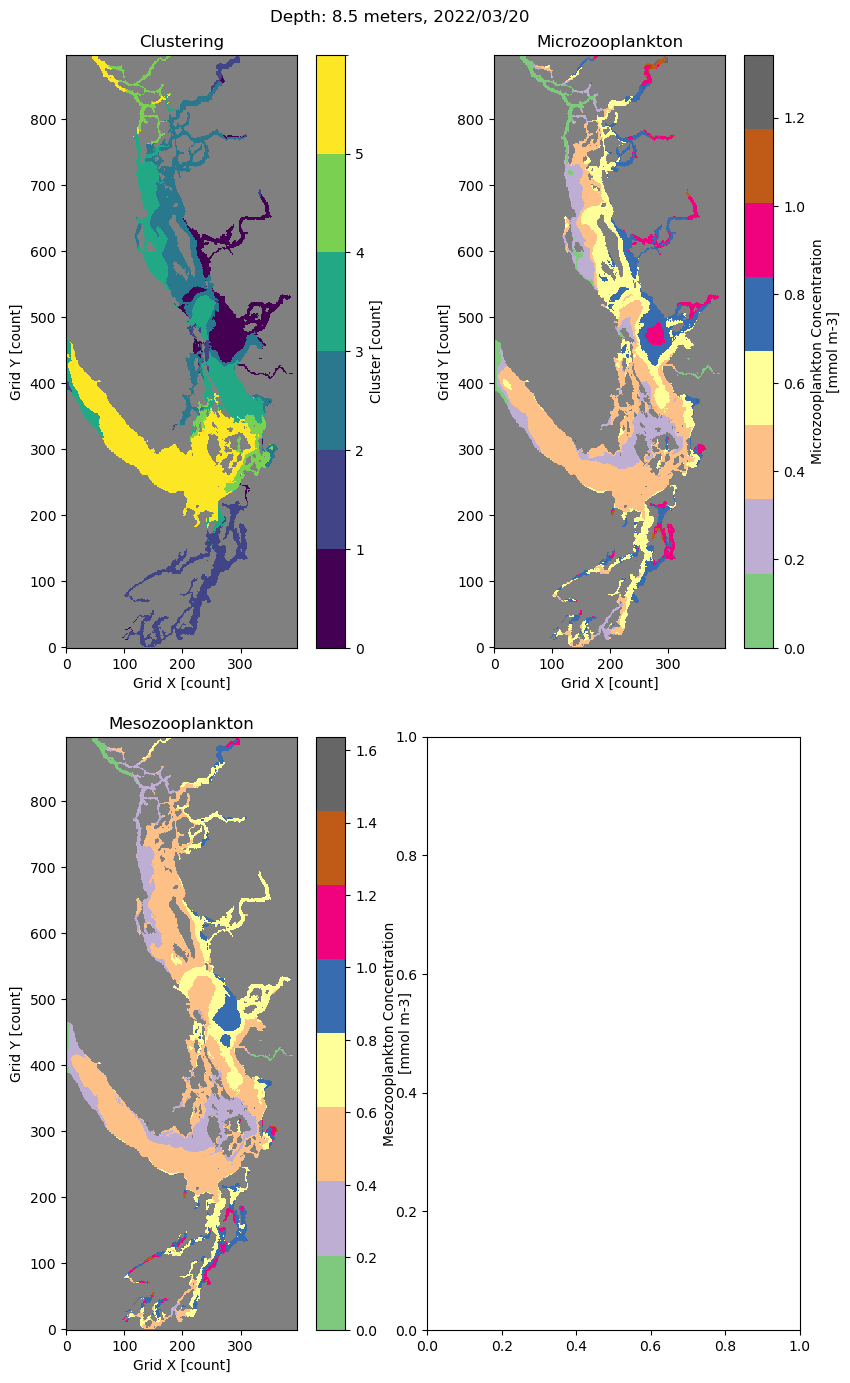

The amount of grid boxes for cluster 0 is 7492 

The minimum temperature for cluster 0 is 5.12 degrees Celsius
The maximum temperature for cluster 0 is 8.85 degrees Celsius
The mean temperature for cluster 0 is 7.52 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 28.01 g/kg
The mean salinity for cluster 0 is 26.03 g/kg 


The amount of grid boxes for cluster 1 is 10124 

The minimum temperature for cluster 1 is 7.92 degrees Celsius
The maximum temperature for cluster 1 is 10.22 degrees Celsius
The mean temperature for cluster 1 is 8.61 degrees Celsius 

The minimum salinity for cluster 1 is 24.27 g/kg
The maximum salinity for cluster 1 is 29.8 g/kg
The mean salinity for cluster 1 is 28.01 g/kg 


The amount of grid boxes for cluster 2 is 17532 

The minimum temperature for cluster 2 is 7.08 degrees Celsius
The maximum temperature for cluster 2 is 7.95 degrees Celsius
The mean temperature for cluster 2 is 7.62 degrees Celsius 

The 

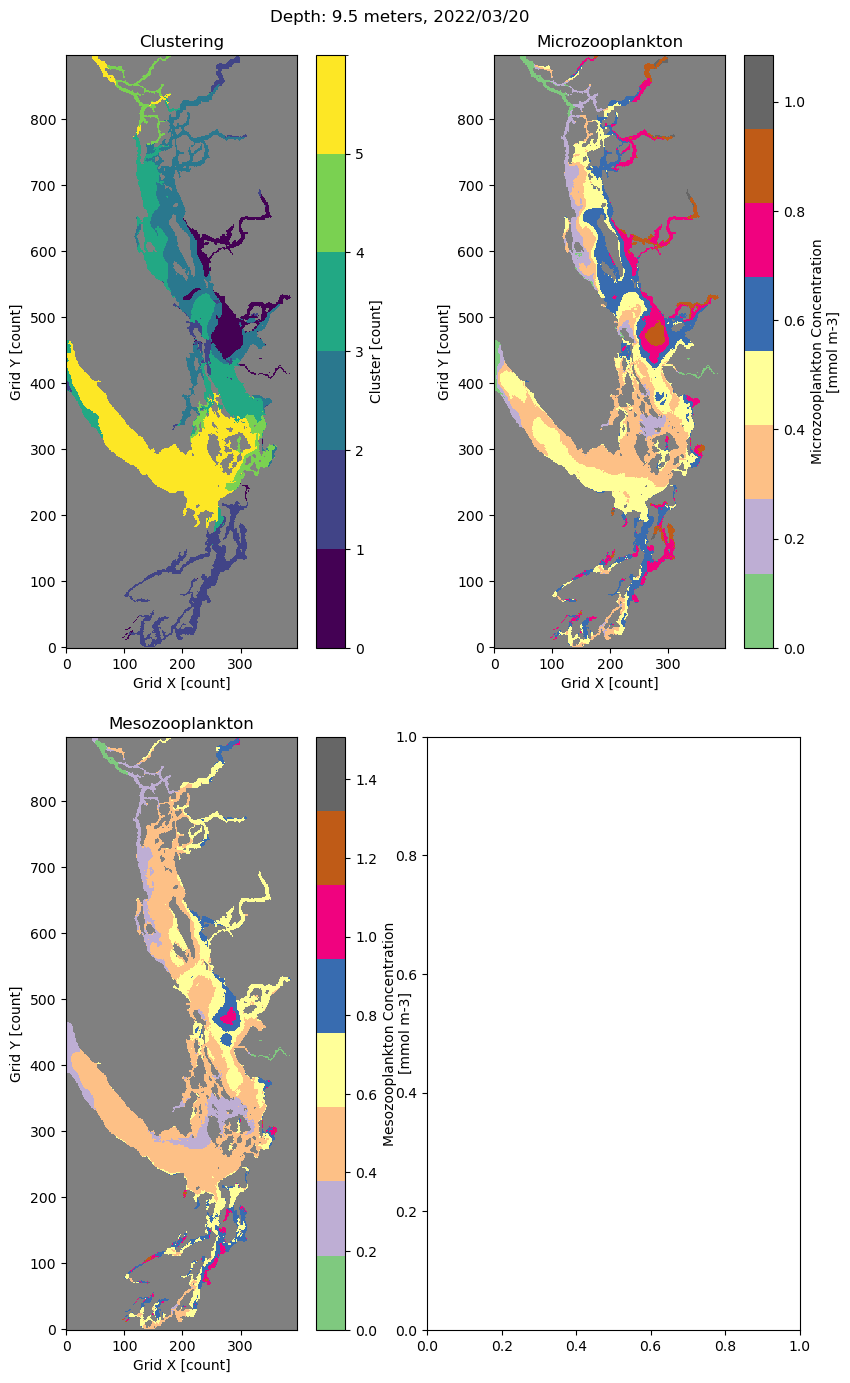

In [61]:
ds, temp, saline, date, mask, micro, meso = datasets_preparation()

for depth in range (0, 10):

    temp, saline, micro, meso = masking(depth, temp, saline, mask, micro, meso)
    unique, counts, inputs, predictions, clusters = som(depth, temp, saline)
    printing(inputs, predictions, unique, counts)
    plotting (depth, clusters, unique, micro, meso)
